In [5]:
#importing all the necessary libraries
import torch
import torch.nn as nn
import torch.functional as F
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader,TensorDataset, random_split, WeightedRandomSampler
import torch.optim as optim
from torchsummary import summary

In [4]:
data=pd.read_excel('pre-processed-data_college_code.xlsx')
inputs=data.drop(['admitted'],axis=1).to_numpy()
labels=data['admitted'].to_numpy()
train_inputs, test_inputs, train_labels, test_labels = train_test_split(
    inputs, labels, test_size=0.2, random_state=42, stratify=labels
)
# Convert to PyTorch tensors only once
train_inputs = torch.from_numpy(train_inputs).float()
test_inputs = torch.from_numpy(test_inputs).float()
train_labels = torch.from_numpy(train_labels).int()
test_labels = torch.from_numpy(test_labels).int()
input_embedding_dimension=len(set(inputs[:,0]))
input_embedding_dimension
#The TensorDataset class in PyTorch is a utility class that is used to wrap data tensors (such as features and labels)
#This class is particularly useful when you want to work with datasets where features and labels are already stored as tensors.
train_dataset = TensorDataset(train_inputs, train_labels)
test_dataset = TensorDataset(test_inputs, test_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
print("Checking train_inputs for NaN:", torch.any(torch.isnan(train_inputs)))
print("Checking train_inputs for Inf:", torch.any(torch.isinf(train_inputs)))
print("Checking train_labels for NaN:", torch.any(torch.isnan(train_labels)))
print("Checking train_labels for Inf:", torch.any(torch.isinf(train_labels)))

Checking train_inputs for NaN: tensor(False)
Checking train_inputs for Inf: tensor(False)
Checking train_labels for NaN: tensor(False)
Checking train_labels for Inf: tensor(False)


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

class NeuralNetwork(nn.Module):
    def __init__(self, i, h_size, h_next_size, h_next_next_size=32, n_classes=2,
                 how_many_layers=4, embedding_dim=12,hs_embedding_dim=50):
        super(NeuralNetwork, self).__init__()

        features = i.shape[1]  # Total number of input features

        self.major_embedding = nn.Embedding(input_embedding_dimension, embedding_dim)

        #embedding layer for the high school codes
        self.hs_embedding=nn.Embedding(len(set(inputs[:,4])),hs_embedding_dim)

        # Input to fc1 will be (features - 2) continuous + embedding_dim
        self.fc1 = nn.Linear(features - 2 + embedding_dim + hs_embedding_dim, h_size)
        self.layers = how_many_layers

        if self.layers == 2:
            self.fc2 = nn.Linear(h_size, n_classes)
        elif self.layers == 3:
            self.fc3 = nn.Linear(h_size, h_next_size)
            self.fc4 = nn.Linear(h_next_size, n_classes)
        elif self.layers == 4:
            self.fc3 = nn.Linear(h_size, h_next_size)
            self.fc4 = nn.Linear(h_next_size, h_next_next_size)
            self.fc5 = nn.Linear(h_next_next_size, n_classes)

    def forward(self, X):
        # Ensure input is float and extract categorical/continuous features
        categorical_input = X[:, 0].long()  # First column: categorical (encoded)
        hs_input = X[:, 4].long()

        #continuous_input = X[:, 1:].float() # Rest: continuous features
        continuous_indices = [i for i in range(X.shape[1]) if i not in [0, 4]]
        continuous_input = X[:, continuous_indices].float()

        # Apply embedding
        embedded = self.major_embedding(categorical_input)  # Shape: [batch_size, embedding_dim]
        hs_embedded = self.hs_embedding(hs_input)

        # Concatenate with continuous features
        X = torch.cat((embedded,hs_embedded, continuous_input), dim=1)  # Shape: [batch_size, embedding_dim + (features-1)]

        if self.layers == 2:
            X = F.relu(self.fc1(X))
            X = self.fc2(X)
        elif self.layers == 3:
            X = F.relu(self.fc1(X))
            X = F.relu(self.fc3(X))
            X = self.fc4(X)
        elif self.layers == 4:
            X = F.relu(self.fc1(X))
            X = torch.tanh(self.fc3(X))
            X = F.sigmoid(self.fc4(X))
            X = self.fc5(X)

        return X


net = NeuralNetwork(inputs, h_size=16, h_next_size=22, how_many_layers=4)
print(f"Expected input features to fc1: {train_inputs.shape[1] - 1 + 8}")  # Debug print
print(f"fc1 weight shape: {net.fc1.weight.shape}")  # Debug printn_epochs = 600


n_epochs = 600
learning_rate = 0.0001
decay_rate = learning_rate / n_epochs
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=decay_rate)
lambda_reg = 0.01
lambda_entropy = 0


def loss_fn(model, outputs, targets):
    # Convert labels to numpy
    y_train = train_labels.numpy()

    # Compute class weights
    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)

    # Convert to PyTorch tensor
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

    cross_entropy = nn.functional.cross_entropy(outputs, targets,weight=class_weights_tensor)
    l2_regularization = 0
    entropy_regularization = 0

    for param in model.parameters():
        l2_regularization += torch.norm(param, p=2) ** 2
        entropy_regularization += torch.mean(torch.sum(-outputs * torch.log(outputs), dim=1))

    loss = cross_entropy + lambda_reg * l2_regularization
    return loss

def test_instance(model):
    y_t = []
    y_s = []
    loss = 0
    acc = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss += loss_fn(model, outputs, labels.long())
            y_t.extend(labels.numpy().astype('int'))
            y_s.extend(torch.sigmoid(outputs).max(axis=1).indices.numpy())

    acc = accuracy_score(y_t, y_s)
    return loss, acc

iteration = 0
counter = 0

for epoch in range(n_epochs):
    running_loss = 0.0
    total = 0  # No. of total predictions
    correct = 0  # No. of correct predictions

    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = loss_fn(net, outputs, labels.long())
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / len(train_loader.dataset)  # Loss in every epoch
    epoch_acc = correct / total  # Accuracy for every epoch

    if epoch % 10 == 0 or epoch == n_epochs - 1:
        print(f'Epoch: {epoch + 1}/{n_epochs} | pLoss: {running_loss / len(inputs)} | Accuracy: {epoch_acc} | Loss: {epoch_loss}')

    if epoch % 50 == 0:
        test_loss, test_acc = test_instance(net)
        print(f'Epoch: {epoch + 1} | The test data Accuracy = {test_acc} | Test Loss = {test_loss}')

        if counter < test_acc:
            save_net = net
            counter = test_acc

y_true = []
y_scores = []
test_loss = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = save_net(inputs)
        test_loss += loss_fn(net, outputs, labels.long())
        y_true.extend(labels.numpy().astype('int'))
        y_scores.extend(torch.sigmoid(outputs).max(axis=1).indices.numpy())


accuracy = accuracy_score(y_true, y_scores)
precision = precision_score(y_true, y_scores)
recall = recall_score(y_true, y_scores)
f1_val = f1_score(y_true, y_scores)
auc_roc = roc_auc_score(y_true, y_scores)

print('Accuracy: {:.4f}'.format(accuracy))
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))
print('F1 Score: {:.4f}'.format(f1_val))
print('AUROC Score: {:.4f}'.format(auc_roc))


Expected input features to fc1: 55
fc1 weight shape: torch.Size([16, 108])
Epoch: 1/600 | pLoss: 807538.0002441406 | Accuracy: 0.6412975670617592 | Loss: 1511.3000628399388
Epoch: 1 | The test data Accuracy = 0.891060291060291 | Test Loss = 56731.97265625
Epoch: 11/600 | pLoss: 635538.6144205729 | Accuracy: 0.9469744229569557 | Loss: 1189.4047680983897
Epoch: 21/600 | pLoss: 498881.9208577474 | Accuracy: 0.9501975462674153 | Loss: 933.6530022290968
Epoch: 31/600 | pLoss: 388279.2595147027 | Accuracy: 0.9533166978581826 | Loss: 726.6611219863431
Epoch: 41/600 | pLoss: 298785.82633463544 | Accuracy: 0.9533166978581826 | Loss: 559.1749713062422
Epoch: 51/600 | pLoss: 227024.6850382487 | Accuracy: 0.9523809523809523 | Loss: 424.87464448830076
Epoch: 51 | The test data Accuracy = 0.9496881496881497 | Test Loss = 15916.4375
Epoch: 61/600 | pLoss: 170211.88118489584 | Accuracy: 0.9536286130172593 | Loss: 318.54999597921864
Epoch: 71/600 | pLoss: 125870.77877468533 | Accuracy: 0.95352464129756

Confusion Matrix:
 [[2008  104]
 [   8  285]]


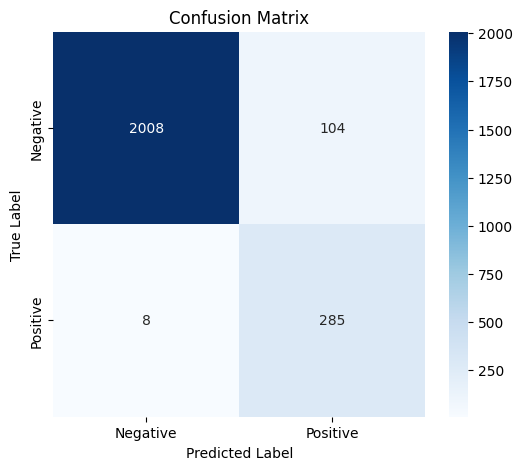

True Positives (TP): 285
False Positives (FP): 104
True Negatives (TN): 2008
False Negatives (FN): 8


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute Confusion Matrix
cm = confusion_matrix(y_true, y_scores)

# Print the matrix
print("Confusion Matrix:\n", cm)

# Plot the Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

from sklearn.metrics import confusion_matrix

# Compute Confusion Matrix
cm = confusion_matrix(y_true, y_scores)

# Extract TP, TN, FP, FN
TN = cm[0, 0]  # True Negative
FP = cm[0, 1]  # False Positive
FN = cm[1, 0]  # False Negative
TP = cm[1, 1]  # True Positive

print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN): {TN}")
print(f"False Negatives (FN): {FN}")


In [17]:
# Save the entire model (architecture + weights)
torch.save(save_net, "/content/full_model.pth")
print("Model saved successfully!")


Model saved successfully!


Index(['Application Major', 'Scholarship_Awarded', 'Application CGPA',
       'FAFSA Filed', 'High School Code', 'Financial Aid Appeal',
       'Accepted Student Day Event Attended', 'Campus Visits - Person',
       'Campus Visits - App', 'Logins Before Admit', 'Acceptance Call Success',
       'Application Consider Test Scores', 'Application ACRK',
       'Waitlist Confirmed Date', 'Emails Sent', 'Emails Opened',
       'Was Inquiry', 'Athlete', 'admitted', 'Address 1 Region_Midwest',
       'Address 1 Region_Northeast', 'Address 1 Region_South',
       'Address 1 Region_Southwest', 'Address 1 Region_Territory',
       'Address 1 Region_West', 'Application Housing_Commuter',
       'Application Housing_Residential',
       'Application Enroll Status_Full Time',
       'Application Enroll Status_Part Time', 'Person Sex_F', 'Person Sex_M',
       'High School Region_Midwest', 'High School Region_Northeast',
       'High School Region_South', 'High School Region_Southwest',
       'High 

<ipython-input-18-396c63a1c90e>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("full_model.pth")


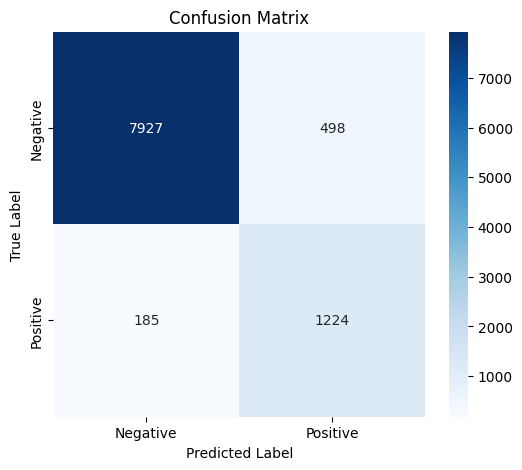

True Positives (TP): 1224
False Positives (FP): 498
True Negatives (TN): 7927
False Negatives (FN): 185


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
data_2023=pd.read_excel('/content/processed_fall_2023.xlsx')
# Ensure that new_data has the same columns as the training data except for the target column
print(data_2023.columns)
new_data = data_2023[data_2023.drop(['admitted'], axis=1).columns]
print(new_data.shape[1])
data_2023_labels=data_2023['admitted'].to_numpy()

# Load the trained model
model = torch.load("full_model.pth")



# Make sure new_data is a PyTorch tensor
new_data_tensor = torch.from_numpy(new_data.to_numpy()).float()

# Perform inference on the new data
with torch.no_grad():
    # Assuming your model is saved in 'save_net' after training
    outputs = model(new_data_tensor)

# Get predicted class labels from the outputs
predictions = torch.argmax(outputs, dim=1)

# If you want the predicted probabilities, you can use:
# probabilities = torch.softmax(outputs, dim=1)

# Convert predictions to numpy for further processing
predictions = predictions.numpy()

print("Predictions on new data:")
print(predictions)
print(len(predictions))


accuracy = accuracy_score(data_2023_labels,predictions)
precision = precision_score(data_2023_labels,predictions)
recall = recall_score(data_2023_labels, predictions)
f1_val = f1_score(data_2023_labels, predictions)
auc_roc = roc_auc_score(data_2023_labels, predictions)

print('Accuracy: {:.4f}'.format(accuracy))
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))
print('F1 Score: {:.4f}'.format(f1_val))
print('AUROC Score: {:.4f}'.format(auc_roc))

# Compute Confusion Matrix
cm = confusion_matrix(data_2023_labels,predictions)

# Plot the Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

from sklearn.metrics import confusion_matrix

# Compute Confusion Matrix
cm = confusion_matrix(data_2023_labels,predictions)

# Extract TP, TN, FP, FN
TN = cm[0, 0]  # True Negative
FP = cm[0, 1]  # False Positive
FN = cm[1, 0]  # False Negative
TP = cm[1, 1]  # True Positive

print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN): {TN}")
print(f"False Negatives (FN): {FN}")
